# CSE527 Homework 6
**Due date: 23:59 on Dec. 5, 2019 (Thursday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
In this homework we are going to work on estimating the 3D pose of a person given their 2D
pose. Turns out, just regressing the 3D pose coordinates using the 2D pose works pretty well [1]
(you can find the paper [here](https://arxiv.org/pdf/1705.03098.pdf)). In Part One, we are going to work on reproducing the results of the
paper, in Part Two, we are going to try to find a way to handle noisy measurement.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

## Benchmark
Train for a least 30 epochs to get a least 44mm avg error. The test result(mm error) should be in the following sequence **direct.	discuss.	eat.	greet.	phone	photo	pose	purch.	sit	sitd.	somke	wait	walkd.	walk	walkT	avg**

## Problem 1:
{60 points} Let us first start by trying to reproduce the testing accuracy obtained by in the [paper]((https://arxiv.org/pdf/1705.03098.pdf) above using
PyTorch. The 2D pose of a person is represented as a set of 2D coordinates for each of their $n = 32$ joints
i.e $P^{2D}_{i }$= {$(x^{1}_{i}, y^{1}_{i}), ...,(x^{32}_{i}, y^{32}_{i})$}, where $(x^{j}_{i}, y^{j}_{i})$ are the 2D coordinates of the $j$’th joint of the i’th sample. Similarly, the 3D pose of a person is 
$P^{3D}_{i}$ = {$(x^{1}_{i}, y^{1}_{i}, z^{1}_{i}), ...,(x^{32}_{i}, y^{32}_{i}, z^{32}_{i})$}, 
where $(x^{j}_{i}, y^{j}_{i}, z^{j}_{i})$ are the 3D coordinates of the $j$’th joint of the $i$’th sample. The only data given to you is the ground
truth 3D pose and the 2D pose calculated using the camera parameters. 
You are going to train a network $f_{θ} : R^{2n} → R^{3n}$ that takes as input the $P^{2D}_{i}$ and tries to regress the ground truth 3D pose $P^{3D}_{i}$. The loss function to train this network would be the $L2$ loss between the ground truth and the predicted pose
\begin{equation*}
L(\theta) = \sum^{M}_{i=1}(P^{3D}_{i} - f_{\theta}(P^{2D}_{i}))^{2} ;\;\;\;\;\;\;\;\; \text{for a minibatch of size M} \;\;\;\;\;\;\;\; (2)
\end{equation*}

**Bonus**: Every 1mm drop in test error from 44mm till 40mm gets you 2 extra points, and every 1mm drop below 40mm gets you 4 extra points.

In [2]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Set your working directory (in your google drive), '/content/gdrive/My Drive/CSE-527-Intro-To-Computer-Vision/hw06/src' is just an example, 
#   change it to your specific homework directory and src.
# Note that Surname_Givenname_SBUID_hw6.ipynb is in the same level of the folder src.

# The structure is like
# Surname_Givenname_SBUID_hw6
#        |---Surname_Givenname_SBUID_hw6.ipynb
#        |---src/*
cd '/content/gdrive/My Drive/Duppala_Sai_112684112_hw6/src'

/content/gdrive/My Drive/Duppala_Sai_112684112_hw6/src


In [4]:
pip install pykalman

     |████████████████████████████████| 235kB 7.0MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-cp36-none-any.whl size=48464 sha256=618a42f649280e51e4b4bbf525573b3e311024657e99b2bf7c16c7c84e92eef0
  Stored in directory: /root/.cache/pip/wheels/d9/e8/6a/553d9832679cb74a8434fa597c3abdb07313e40054a0adf9ac
Successfully built pykalman


In [0]:
from __future__ import print_function, absolute_import, division

import os
import sys
import time
from pprint import pprint
import numpy as np

import torch
import torch.nn as nn
import torch.optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torch.autograd import Variable

# Locate to the src folder to import the following functions.
from procrustes import get_transformation
import data_process as data_process
import data_utils
from progress.progress.bar import Bar as Bar
import utils as utils
import misc as misc
import log as log
import cameras
1
from pykalman import KalmanFilter
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt

In [0]:
action = 'All'
actions = data_utils.define_actions( action )
cameras_path = "./data/h36m/cameras.h5"
TRAIN_TEST_ID = [1,5,6,7,8,9,11]
rcams = cameras.load_cameras(cameras_path, TRAIN_TEST_ID)

In [7]:
# Load data
data_dir = './data/h36m/'
camera_frame = True
predict_14 = False
# Load 3d data and load (or create) 2d projections
train_set_3d, test_set_3d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d, train_root_positions, test_root_positions = data_utils.read_3d_data(
    actions, data_dir, camera_frame, rcams, predict_14 )

Reading subject 1, action Directions
./data/h36m/S1/MyPoses/3D_positions/Directions*.h5
./data/h36m/S1/MyPoses/3D_positions/Directions.h5
./data/h36m/S1/MyPoses/3D_positions/Directions 1.h5
Reading subject 1, action Discussion
./data/h36m/S1/MyPoses/3D_positions/Discussion*.h5
./data/h36m/S1/MyPoses/3D_positions/Discussion 1.h5
./data/h36m/S1/MyPoses/3D_positions/Discussion.h5
Reading subject 1, action Eating
./data/h36m/S1/MyPoses/3D_positions/Eating*.h5
./data/h36m/S1/MyPoses/3D_positions/Eating.h5
./data/h36m/S1/MyPoses/3D_positions/Eating 2.h5
Reading subject 1, action Greeting
./data/h36m/S1/MyPoses/3D_positions/Greeting*.h5
./data/h36m/S1/MyPoses/3D_positions/Greeting 1.h5
./data/h36m/S1/MyPoses/3D_positions/Greeting.h5
Reading subject 1, action Phoning
./data/h36m/S1/MyPoses/3D_positions/Phoning*.h5
./data/h36m/S1/MyPoses/3D_positions/Phoning.h5
./data/h36m/S1/MyPoses/3D_positions/Phoning 1.h5
Reading subject 1, action Photo
./data/h36m/S1/MyPoses/3D_positions/Photo*.h5
./data/h

/content/gdrive/My Drive/Duppala_Sai_112684112_hw6/src/data_utils.py:462: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  complete_train = copy.deepcopy( np.vstack( train_set.values() ))


In [8]:
# Read stacked hourglass 2D predictions if use_sh, otherwise use groundtruth 2D projections
#use stacked hourgalss
use_sh = False
if use_sh:
    train_set_2d, test_set_2d, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d = data_utils.read_2d_predictions(actions, data_dir)
else:
    train_set_2d, test_set_2d, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d = data_utils.create_2d_data( actions, data_dir, rcams )
print( "done reading and normalizing data." )

stat_3d = {}
stat_3d['mean'] = data_mean_3d
stat_3d['std'] = data_std_3d
stat_3d['dim_use'] = dim_to_use_3d

Reading subject 1, action Directions
./data/h36m/S1/MyPoses/3D_positions/Directions*.h5
./data/h36m/S1/MyPoses/3D_positions/Directions.h5
./data/h36m/S1/MyPoses/3D_positions/Directions 1.h5
Reading subject 1, action Discussion
./data/h36m/S1/MyPoses/3D_positions/Discussion*.h5
./data/h36m/S1/MyPoses/3D_positions/Discussion 1.h5
./data/h36m/S1/MyPoses/3D_positions/Discussion.h5
Reading subject 1, action Eating
./data/h36m/S1/MyPoses/3D_positions/Eating*.h5
./data/h36m/S1/MyPoses/3D_positions/Eating.h5
./data/h36m/S1/MyPoses/3D_positions/Eating 2.h5
Reading subject 1, action Greeting
./data/h36m/S1/MyPoses/3D_positions/Greeting*.h5
./data/h36m/S1/MyPoses/3D_positions/Greeting 1.h5
./data/h36m/S1/MyPoses/3D_positions/Greeting.h5
Reading subject 1, action Phoning
./data/h36m/S1/MyPoses/3D_positions/Phoning*.h5
./data/h36m/S1/MyPoses/3D_positions/Phoning.h5
./data/h36m/S1/MyPoses/3D_positions/Phoning 1.h5
Reading subject 1, action Photo
./data/h36m/S1/MyPoses/3D_positions/Photo*.h5
./data/h

/content/gdrive/My Drive/Duppala_Sai_112684112_hw6/src/data_utils.py:419: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  complete_train = copy.deepcopy( np.vstack( train_set.values() ))


done reading and normalizing data.


In [0]:
# ============================
#   Define Train/Test Methods
# ============================

def train(train_loader, model, criterion, optimizer,
          lr_init=None, lr_now=None, glob_step=None, lr_decay=None, gamma=None,
          max_norm=True):
    losses = utils.AverageMeter()

    model.train()

    start = time.time()
    batch_time = 0
    bar = Bar('>>>', fill='>', max=len(train_loader))

    for i, (inps, tars) in enumerate(train_loader):
        glob_step += 1
        if glob_step % lr_decay == 0 or glob_step == 1:
            lr_now = utils.lr_decay(optimizer, glob_step, lr_init, lr_decay, gamma)
        inputs = Variable(inps.cuda())
        targets = Variable(tars.cuda(async=True))

        outputs = model(inputs)

        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        losses.update(loss.item(), inputs.size(0))
        loss.backward()
        if max_norm:
            nn.utils.clip_grad_norm(model.parameters(), max_norm=1)
        optimizer.step()

        if (i + 1) % 100 == 0:
            batch_time = time.time() - start
            start = time.time()

        bar.suffix = '({batch}/{size}) | batch: {batchtime:.4}ms | Total: {ttl} | ETA: {eta:} | loss: {loss:.4f}' \
            .format(batch=i + 1,
                    size=len(train_loader),
                    batchtime=batch_time * 10.0,
                    ttl=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg)
        bar.next()

    bar.finish()
    return glob_step, lr_now, losses.avg

def test(test_loader, model, criterion, stat_3d, procrustes=True):
    losses = utils.AverageMeter()

    model.eval()

    all_dist = []
    start = time.time()
    batch_time = 0
    bar = Bar('>>>', fill='>', max=len(test_loader))

    for i, (inps, tars) in enumerate(test_loader):
        inputs = Variable(inps.cuda())
        targets = Variable(tars.cuda(async=True))
        outputs = model(inputs)

        # calculate loss
        outputs_coord = outputs
        loss = criterion(outputs_coord, targets)

        losses.update(loss.item(), inputs.size(0))

        tars = targets

        # calculate
        targets_unnorm = data_process.unNormalizeData(tars.data.cpu().numpy(), stat_3d['mean'], stat_3d['std'], stat_3d['dim_use'])
        outputs_unnorm = data_process.unNormalizeData(outputs.data.cpu().numpy(), stat_3d['mean'], stat_3d['std'], stat_3d['dim_use'])

        # remove dim ignored
        dim_use = np.hstack((np.arange(3), stat_3d['dim_use']))

        outputs_use = outputs_unnorm[:, dim_use]
        targets_use = targets_unnorm[:, dim_use]

        if procrustes:
            for ba in range(inps.size(0)):
                gt = targets_use[ba].reshape(-1, 3)
                out = outputs_use[ba].reshape(-1, 3)
                _, Z, T, b, c = get_transformation(gt, out, True)
                out = (b * out.dot(T)) + c
                outputs_use[ba, :] = out.reshape(1, 51)

        sqerr = (outputs_use - targets_use) ** 2

        distance = np.zeros((sqerr.shape[0], 17))
        dist_idx = 0
        for k in np.arange(0, 17 * 3, 3):
            distance[:, dist_idx] = np.sqrt(np.sum(sqerr[:, k:k + 3], axis=1))
            dist_idx += 1
        all_dist.append(distance)

        # update summary
        if (i + 1) % 100 == 0:
            batch_time = time.time() - start
            start = time.time()

        bar.suffix = '({batch}/{size}) | batch: {batchtime:.4}ms | Total: {ttl} | ETA: {eta:} | loss: {loss:.6f}' \
            .format(batch=i + 1,
                    size=len(test_loader),
                    batchtime=batch_time * 10.0,
                    ttl=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg)
        bar.next()

    all_dist = np.vstack(all_dist)
    joint_err = np.mean(all_dist, axis=0)
    ttl_err = np.mean(all_dist)
    bar.finish()
    print (">>> error: {} <<<".format(ttl_err))
    return losses.avg, ttl_err

In [0]:
# ==================
#   Dataset class
# ==================
from torch.utils.data import Dataset

#S
TRAIN_SUBJECTS = [1, 5, 6, 7, 8]
TEST_SUBJECTS = [9, 11]

#S
class Human36M(Dataset):
    def __init__(self, actions, data_path, use_hg=True, is_train=True):
        """
        :param actions: list of actions to use
        :param data_path: path to dataset
        :param use_hg: use stacked hourglass detections
        :param is_train: load train/test dataset
        """

        # Write you code here

        self.is_train = is_train
        self.use_hg = use_hg

        self.actions = actions
        self.data_path = data_path


        self.train_inp, self.train_out, self.test_inp, self.test_out = [], [], [], []

        # loading data
        if self.use_hg:
            train_2d_file = train_set_2d
            test_2d_file = test_set_2d
        else:
            train_2d_file = train_set_2d
            test_2d_file = test_set_2d

        if self.is_train:
            self.train_3d = train_set_3d
            self.train_2d = train_2d_file
            for k2d in self.train_2d.keys():
                (s, a, filename) = k2d
                k3d = k2d
                k3d = (s, a, filename[:-3]) if filename.endswith('-sh') else k3d
                num_f, _ = self.train_2d[k2d].shape
                for i in range(0, num_f):
                    self.train_inp.append(self.train_2d[k2d][i])
                    self.train_out.append(self.train_3d[k3d][i])

        else:
            self.test_3d = test_set_3d
            self.test_2d =  test_2d_file
            for k2d in self.test_2d.keys():
                (s, a, filename) = k2d
                if a not in self.actions:
                    continue
                k3d = k2d
                k3d = (s, a, filename[:-3]) if filename.endswith('-sh') else k3d
                num_f, _ = self.test_2d[k2d].shape
                for i in range(0, num_f):
                    self.test_inp.append(self.test_2d[k2d][i])
                    self.test_out.append(self.test_3d[k3d][i])
        
    def __getitem__(self, index):
        if self.is_train:
            inputs = torch.from_numpy(self.train_inp[index]).float()
            outputs = torch.from_numpy(self.train_out[index]).float()

        else:
            inputs = torch.from_numpy(self.test_inp[index]).float()
            outputs = torch.from_numpy(self.test_out[index]).float()

        return inputs, outputs

    def __len__(self):
        if self.is_train:
            return len(self.train_inp)
        else:
            return len(self.test_inp)


In [0]:
# ==========================================
#       Define Network Architecture
# ==========================================
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal(m.weight)


class Linear(nn.Module):
    def __init__(self, linear_size, p_dropout=0.5):
        super(Linear, self).__init__()
        self.l_size = linear_size

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p_dropout)

        self.w1 = nn.Linear(self.l_size, self.l_size)
        self.batch_norm1 = nn.BatchNorm1d(self.l_size)

        self.w2 = nn.Linear(self.l_size, self.l_size)
        self.batch_norm2 = nn.BatchNorm1d(self.l_size)

    def forward(self, x):
        y = self.w1(x)
        y = self.batch_norm1(y)
        y = self.relu(y)
        y = self.dropout(y)

        y = self.w2(y)
        y = self.batch_norm2(y)
        y = self.relu(y)
        y = self.dropout(y)

        out = x + y
        return out


class LinearModel(nn.Module):
    def __init__(self,
                 linear_size=1024,
                 num_stage=2,
                 p_dropout=0.5):
        super(LinearModel, self).__init__()

        self.linear_size = linear_size
        self.p_dropout = p_dropout
        self.num_stage = num_stage

        # 2d joints
        self.input_size =  16 * 2
        # 3d joints
        self.output_size = 16 * 3

        # process input to linear size
        self.w1 = nn.Linear(self.input_size, self.linear_size)
        self.batch_norm1 = nn.BatchNorm1d(self.linear_size)

        self.linear_stages = []
        for l in range(0, num_stage):
            self.linear_stages.append(Linear(self.linear_size, self.p_dropout))
        self.linear_stages = nn.ModuleList(self.linear_stages)

        # post processing
        self.w2 = nn.Linear(self.linear_size, self.output_size)

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(self.p_dropout)

    def forward(self, x):
        # pre-processing
        y = self.w1(x)
        y = self.batch_norm1(y)
        y = self.relu(y)
        y = self.dropout(y)

        # linear layers
        for i in range(0, self.num_stage):
            y = self.linear_stages[i](y)

        y = self.w2(y)

        return y


In [0]:

#ALL VARIABLES
action = 'All'
lr_decay = 100000
lr_gamma = 0.96

# dropout = 0.5
train_batch = 64
test_batch = 64
job = 8
lr = 0.001
lr_now = lr

#default values
max_norm = True
procrustes = True

data_dir = './data/h36m/'

epochs = 41
use_hg = False

start_epoch = 0
err_best = 1000
glob_step = 0

#FEATURE IF CHECKPOINT IS INTRODUCED
# lr_now = 1.0e-3


In [25]:

# ==========================================
#         Create Model
# ==========================================

print(">> creating model")
model = LinearModel()
model = model.cuda()
model.apply(weight_init)
print(">> total params: {:.2f}M".format(sum(p.numel() for p in model.parameters()) / 1000000.0))
criterion = nn.MSELoss(size_average=True).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

>> creating model
>> total params: 4.29M


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [0]:
# ==========================================
#         Optimize/Train Network
# ==========================================

def LoadAndTrainNetwork():
    actions = misc.define_actions(action)
    num_actions = len(actions)
    print(">> actions to use (total: {}):".format(num_actions))
    pprint(actions, indent=4)
    print("-----------------")

    print(">>> loading data")
    test_loader = DataLoader(
        dataset=Human36M(actions=actions, data_path=data_dir, use_hg=use_hg, is_train=False),
        batch_size=test_batch,
        shuffle=False,
        num_workers=job,
        pin_memory=True)
    train_loader = DataLoader(
        dataset=Human36M(actions=actions, data_path=data_dir, use_hg=use_hg),
        batch_size=train_batch,
        shuffle=True,
        num_workers= job,
        pin_memory=True)
    print(">> data loaded !")

    #finds best algorithm
    cudnn.benchmark = True

    #VARIABLES AGAIN
    lr_now = lr
    glob_step = 0

    for epoch in range(start_epoch, epochs):

        print('-------------------------')
        print('>> epoch: {} | lr: {:.5f}'.format(epoch + 1, lr_now))

        # per epoch
        glob_step, lr_now, loss_train = train(
            train_loader, model, criterion, optimizer,
            lr_init=lr, lr_now=lr_now, glob_step=glob_step, lr_decay=lr_decay, gamma=lr_gamma,
            max_norm=max_norm)
        loss_test, err_test = test(test_loader, model, criterion, stat_3d, procrustes=procrustes)

In [27]:
LoadAndTrainNetwork()

>> actions to use (total: 15):
[   'Directions',
    'Discussion',
    'Eating',
    'Greeting',
    'Phoning',
    'Photo',
    'Posing',
    'Purchases',
    'Sitting',
    'SittingDown',
    'Smoking',
    'Waiting',
    'WalkDog',
    'Walking',
    'WalkTogether']
-----------------
>>> loading data
>> data loaded !
-------------------------
>> epoch: 1 | lr: 0.00100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


>>> error: 44.61558488289444 <<<
-------------------------
>> epoch: 2 | lr: 0.00100
>>> error: 41.42454380198392 <<<
-------------------------
>> epoch: 3 | lr: 0.00100
>>> error: 41.12992776803886 <<<
-------------------------
>> epoch: 4 | lr: 0.00100
>>> error: 40.15279648385778 <<<
-------------------------
>> epoch: 5 | lr: 0.00100
>>> error: 39.849964621552516 <<<
-------------------------
>> epoch: 6 | lr: 0.00096
>>> error: 39.30832302377496 <<<
-------------------------
>> epoch: 7 | lr: 0.00096
>>> error: 39.04802092232803 <<<
-------------------------
>> epoch: 8 | lr: 0.00096
>>> error: 38.586324003295466 <<<
-------------------------
>> epoch: 9 | lr: 0.00096
>>> error: 38.224796593919415 <<<
-------------------------
>> epoch: 10 | lr: 0.00092
>>> error: 37.65704731392935 <<<
-------------------------
>> epoch: 11 | lr: 0.00092
>>> error: 38.29980524880386 <<<
-------------------------
>> epoch: 12 | lr: 0.00092
>>> error: 37.88168626733082 <<<
-------------------------


In [28]:
# ==========================================
#            Evaluating Network
# ==========================================

err_set = []
actions = misc.define_actions(action)
for action in actions:
    print (">> TEST on _{}_".format(action))
    test_loader = DataLoader(
                dataset=Human36M(actions=action, data_path=data_dir, use_hg=use_hg, is_train=False),
                batch_size=test_batch,
                shuffle=False,
                num_workers=job,
                pin_memory=True)
    _, err_test = test(test_loader, model, criterion, stat_3d, procrustes=procrustes)
    err_set.append(err_test)

print (">>>> TEST RESULTS:")
for action in actions:
    print ("{}".format(action), end='\t')
print ("\n")
for err in err_set:
    print ("{:.4f}".format(err), end='\t')
print (">>>\nERRORS: {}".format(np.array(err_set).mean()))

>> TEST on _Directions_
>>> error: 30.190593844799697 <<<
>> TEST on _Discussion_
>>> error: 35.283030135461445 <<<
>> TEST on _Eating_
>>> error: 33.424011497539844 <<<
>> TEST on _Greeting_
>>> error: 36.11259421278929 <<<
>> TEST on _Phoning_
>>> error: 36.35138825546546 <<<
>> TEST on _Photo_
>>> error: 42.00611111897527 <<<
>> TEST on _Posing_
>>> error: 34.99320144309664 <<<
>> TEST on _Purchases_
>>> error: 32.68763903230562 <<<
>> TEST on _Sitting_
>>> error: 42.64839092414036 <<<
>> TEST on _SittingDown_
>>> error: 44.95113179117829 <<<
>> TEST on _Smoking_
>>> error: 37.3229338971063 <<<
>> TEST on _Waiting_
>>> error: 36.83403886991926 <<<
>> TEST on _WalkDog_
>>> error: 39.230265753356036 <<<
>> TEST on _Walking_
>>> error: 30.623118762676427 <<<
>> TEST on _WalkTogether_
>>> error: 32.59372019443616 <<<
>>>> TEST RESULTS:
Directions	Discussion	Eating	Greeting	Phoning	Photo	Posing	Purchases	Sitting	SittingDown	Smoking	Waiting	WalkDog	Walking	WalkTogether	

30.1906	35.2830	3

Report the test result(mm error) in the following sequence **direct.	discuss.	eat.	greet.	phone	photo	pose	purch.	sit	sitd.	somke	wait	walkd.	walk	walkT	avg**

## Problem 2:
{40 points} In this task, we’re going to tackle the situation of having a faulty 3D sensor. Since the sensor is quite old it’s joint detections are quite noisy:
\begin{equation*}
 \hat{x} = x_{GT} + \epsilon_x \\
 \hat{y} = y_{GT} + \epsilon_y \\
 \hat{z} = z_{GT} + \epsilon_z
\end{equation*}

Where, ($x_{GT}, y_{GT}, z_{GT}$) are the ground truth joint locations, ($\hat{x}, \hat{y}, \hat{z}$) are the noisy measurements detected by our sensor and ($\epsilon_x, \epsilon_y, \epsilon_z$) are the noise values. Being grad students, we’d much rather the department spend money for free coffee and doughnuts than on a new 3D sensor. Therefore, you’re going to denoise the noisy data using a linear Kalman filter.

**Modelling the state using velocity and acceleration**: We assume a simple, if unrealistic model, of our system - we’re only going to use the position, velocity and acceleration of the joints to denoise the data. The underlying equations representing our assumptions are:
\begin{equation}
 x_{t+1} = x_{t} + \frac{\partial x_t}{\partial t} \delta t + 0.5*\frac{\partial^2 x_t}{\partial t^2} \delta t^2 \quad\quad (1)\\ 
 y_{t+1} = y_{t} + \frac{\partial y_t}{\partial t} \delta t + 0.5*\frac{\partial^2 y_t}{\partial t^2} \delta t^2 \quad\quad (2)\\
  z_{t+1} = z_{t} + \frac{\partial z_t}{\partial t} \delta t + 0.5*\frac{\partial^2 z_t}{\partial t^2} \delta t^2 \quad\quad (3) \\
\end{equation}
The only measurements/observations we have (i.e our 'observation space') are the noisy joint locations as recorded by the 3D sensors $o_{t} = (\hat{x}_{t}, \hat{y}_{t}, \hat{z}_{t}$). The corresponding state-space would be $z_{t} = (x_{t}, y_{t}, z_{t}, \frac{\partial x_{t}}{\partial t}, \frac{\partial y_{t}}{\partial t}, \frac{\partial z_{t}}{\partial t}, \frac{\partial^2 x_{t}}{\partial t^2}, \frac{\partial^2 y_{t}}{\partial t^2}, \frac{\partial^2 z_{t}}{\partial t^2})$. 

Formallly, a linear Kalman filter assumes the underlying dynamics of the system to be a linear Gaussian model i.e. 
\begin{equation*}
 z_{0} \sim N(\mu_0, \Sigma_0) \\
 z_{t+1} = A z_{t} + b + \epsilon^1_t \\
 o_{t} = C z_{t} + d + \epsilon^2_t \\
 \epsilon^1_t \sim N(0, Q) \\
 \epsilon^2_t \sim N(0, R)
\end{equation*}
where, $A$ and $C$ are the `transition_matrix` and `observation_matrix` respectively, that you are going to define based on equations (1), (2) and (3). The intitial estimates of other parameters can be assumed as: 

\begin{equation*}
 \texttt{initial_state_mean} := \mu_{0} = mean(given \space data) \\
 \texttt{initial_state_covariance} := \Sigma_{0} = Cov(given \space data) \\
 \texttt{transition_offset} := b = 0 \\
\texttt{observation_offset} := d = 0 \\
 \texttt{transition_covariance} := Q = I \\
 \texttt{observation_covariance} :=R = I \\
\end{equation*}
 
The covariance matrices $Q$ and $R$ are hyperparameters that we initalize as identity matrices. In the code below, you must define $A$ and $C$ and use [pykalman](https://pykalman.github.io/), a dedicated library for kalman filtering in python, to filter out the noise in the data. 

(**Hint:** \\
Gradients could be calculated using `np.gradient` or manually using finite differences \\
You can assume the frame rate to be 50Hz)

For more detailed resources related to Kalman filtering, please refer to: \\
http://web.mit.edu/kirtley/kirtley/binlustuff/literature/control/Kalman%20filter.pdf \\
https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/ \\
https://stanford.edu/class/ee363/lectures/kf.pdf

In [29]:
x = np.array([[ 0.,   1.,   2.,   3.],
       [ 4.,   5.,   6.,   7.],
       [ 8.,   9.,  10.,  11.],
       [12.,  13.,  14.,  15.]])
np.hsplit(x, 4)

[array([[ 0.],
        [ 4.],
        [ 8.],
        [12.]]), array([[ 1.],
        [ 5.],
        [ 9.],
        [13.]]), array([[ 2.],
        [ 6.],
        [10.],
        [14.]]), array([[ 3.],
        [ 7.],
        [11.],
        [15.]])]

In [0]:
'''=================Function definition of the Kalman filter, which will return the filtered 3D world coordinates============================'''
'''=================Students need to fill this part================================'''


from pykalman import KalmanFilter

def KF_filter(full_data):
    '''--------Define the Kalman filter and filter the noisy signal------------'''

    t = 1/50
    all_joints_data = np.hsplit(full_data,16)

    print(len(all_joints_data))
    filtered_all_joints_data = None

    for i, measurements in enumerate(all_joints_data):

        print(measurements)
        # Transition Matrix
        # A = np.array([[1, 1, 1, t, t, t, 0.5 * (t**2),0.5 * (t**2),0.5 * (t**2)],
        #         [0, 1, 1, 1, t, t, t, 0.5 * (t**2), 0.5 * (t**2)],
        #         [0, 0, 1, 1, 1, t, t, t, 0.5 * (t**2)],
        #         [0, 0, 0, 1, 1, 1, t, t, t],
        #         [0, 0, 0, 0, 1, 1, 1, t, t],
        #         [0, 0, 0, 0, 0, 1, 1, 1, t],
        #         [0, 0, 0, 0, 0, 0, 1, 1, 1],
        #         [0, 0, 0, 0, 0, 0, 0, 1, 1],
        #         [0, 0, 0, 0, 0, 0, 0, 0, 1]])
        A = np.array([[1, t, 0.5 * (t**2)],
                [0, 1,            t],
                [0, 0,            1]])

        # Observation Matrix
        C = [[1, 0, 0], [0, 1, 0],[0, 0, 1]]
        # C = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0, 0, 0]]
        
        kf = KalmanFilter(transition_matrices = A, observation_matrices = C, n_dim_state=3)
        # print('got here 2')
        # (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
        (smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

        # print('got here 3')
        # print(smoothed_state_means.shape, smoothed_state_covariances.shape)

        
        if i == 0:
            filtered_all_joints_data = smoothed_state_means
            continue
        print(filtered_all_joints_data.shape)
        filtered_all_joints_data = np.column_stack([filtered_all_joints_data, smoothed_state_means])

    return filtered_all_joints_data

In [33]:
noisy_stat = []
recovered_stat = []

for keys in list(train_set_3d.keys())[:40]:
    
    true_state = train_set_3d[keys]
    #Covariance matrix
    cov = np.cov(true_state.T)

    #noise with mean = 0, cov = cov, size = 1383
    noise = np.random.multivariate_normal(mean = np.zeros(true_state.shape[1]), cov = cov, size = true_state.shape[0])
    noisy_observation = true_state + noise
    
    filtered_observation = KF_filter(noisy_observation)
    
    noisy_stat.append(mean_squared_error(true_state, noisy_observation))
    recovered_stat.append(mean_squared_error(true_state, filtered_observation))

16
[[ 0.63419005  1.01643139  0.93652069]
 [ 1.14097049  0.58999068  0.95433732]
 [ 2.0265782   1.0543505   0.09296499]
 ...
 [ 2.15050103 -0.36298198  0.71698611]
 [ 0.877787   -0.59588817  0.86009483]
 [ 0.52886655 -0.55357525  1.0779376 ]]
[[ 0.13395983  0.39569281  0.89851037]
 [ 0.15182498  0.37176906  0.86352012]
 [ 0.65624721  0.43536499  0.59705601]
 ...
 [ 1.36645008  0.57610735 -0.01659885]
 [ 0.55212325  0.54859975  0.06945155]
 [ 0.46432972  0.49837631  0.28105415]]
(1383, 3)
[[ 1.17307633  0.5388043   0.1070621 ]
 [ 0.85240295  0.5339386   0.16385154]
 [ 1.02481399  0.64408794 -0.18878953]
 ...
 [ 0.84992198  0.88108626 -0.5915768 ]
 [ 0.31304418  0.7622734  -0.0924735 ]
 [ 0.68109788  0.69275461  0.09169101]]
(1383, 6)
[[-0.63419487 -1.016435   -0.93652775]
 [-1.14097891 -0.58999077 -0.95434409]
 [-2.02659334 -1.05435237 -0.09296543]
 ...
 [-2.15051709  0.36299141 -0.71699134]
 [-0.87779342  0.5958964  -0.86010096]
 [-0.52887059  0.55358133 -1.07794579]]
(1383, 9)
[[-0.14

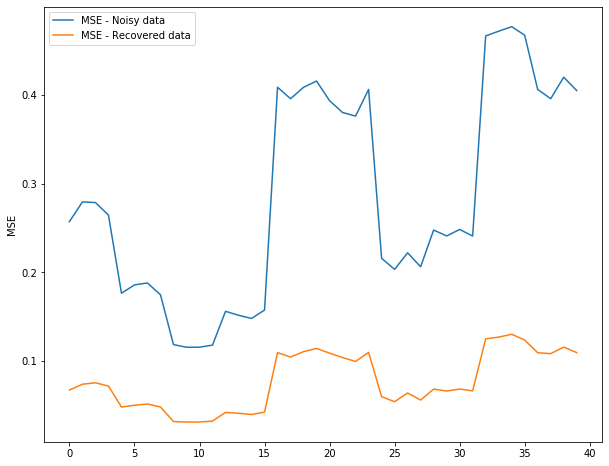

In [34]:
## Plotting the results (tentetive)
# complete this
fig = plt.figure(figsize=(10,8))
plt.plot(noisy_stat, label = 'MSE - Noisy data')
plt.plot(recovered_stat, label = 'MSE - Recovered data')
plt.ylabel('MSE')
plt.legend()

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw6' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.py
```
where Surname_Givenname_SBUID_hw*.py is the Python code of Surname_Givenname_SBUID_hw*.ipynb, which can be dowloaded by File->Download .py.

For instance, student Michael Jordan should submit a zip file named "Jordan_Michael_111134567_hw6.zip" for homework6 in this structure:
```
Jordan_Michael_111134567_hw6
        |---Jordan_Michael_111134567_hw6.ipynb
        |---Jordan_Michael_111134567_hw6.py
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link**. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter two TA's emails: ***bo.cao.1@stonybrook.edu*** and ***sayontan.ghosh@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.

# References
[1] J. Martinez, R. Hossain, J. Romero, and J. J. Little, “A simple yet effective baseline for 3d human pose
estimation,” in ICCV, 2017.

<!--Write your report here in markdown or html-->
